# LLM Pipeline: From Text to Tokens to Embeddings

In this notebook, we’ll walk through a simplified Large Language Model (LLM) pipeline, showing how raw, human-readable text is transformed into numerical representations that a model can understand.

We’ll start with plain text, convert it into tokens, and then transform those tokens into dense numerical vectors called embeddings. These embeddings are what allow models to understand meaning, compare similarity, and reason about language.

---

## What This Notebook Covers

By the end of this notebook, you will understand how:

- Raw text is broken into tokens
- Tokens are mapped to numerical token IDs
- Token IDs are converted into embedding vectors
- Embeddings capture semantic meaning
- Similar pieces of text produce similar embeddings
- Embeddings can be visualized and compared

---

## A More Technically Accurate View of the Pipeline

This process is often summarized as:

**Text → Tokens → Embeddings**

But internally, it looks more like this:

**Text → Tokenization → Token IDs → Embedding Vectors → Model Processing**

Here’s what that means:

- **Tokenization** splits text into smaller units called tokens.
- Each token is mapped to a **token ID** from the model’s vocabulary.
- Token IDs are converted into **embedding vectors**—dense numerical representations that capture semantic meaning.
- These embeddings are what the model actually processes internally.

This notebook focuses on the early and most important part of that flow: how text becomes vectors.


## Prerequisites

- Create Virtual Environment

    Example:
```bash
        uv venv --python=python3.12
        source .venv/bin/activate
        uv pip install -r requirements.txt -q
```

## Import Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Numerical and ML libraries
import numpy as np
from sklearn.decomposition import PCA

# NLP and transformer libraries
from sentence_transformers import SentenceTransformer
import sentence_transformers
from transformers import AutoTokenizer
import transformers

# Visualization libraries
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns


---

## Text Input

**What:** We start with raw, human-readable text - the fundamental input to any LLM processing pipeline.

**Why it's important:** Text is the starting point of all NLP tasks. Understanding how models process different types of text (similar vs. dissimilar topics) helps us see how embeddings capture semantic relationships.

**Implementation:** Creating three sample texts: two about machine learning/AI (similar topics) and one about weather (different topic). This will help us observe how similar texts produce similar embeddings later.

In [2]:
# Sample text inputs
texts = [
    "Machine learning is a method of data analysis that automates analytical model building.",
    "Artificial intelligence enables computers to learn and make decisions from data.",
    "The weather today is sunny and warm."
]

print("Sample Text Inputs:")
print("=" * 70)
for i, text in enumerate(texts, 1):
    print(f"Text {i}: {text}")
print("=" * 70)

Sample Text Inputs:
Text 1: Machine learning is a method of data analysis that automates analytical model building.
Text 2: Artificial intelligence enables computers to learn and make decisions from data.
Text 3: The weather today is sunny and warm.


## Load Tokenizer

**What:** Loading a tokenizer from a transformer model (DistilBERT). The tokenizer converts text into tokens that transformer models can process.

**Why it's important:** Tokenization is the first critical step in the LLM pipeline. The tokenizer breaks text into subword units that the model understands. We'll use the tokenizer to demonstrate how text is converted to tokens in the next step.

**Implementation:** Loading the DistilBERT tokenizer, which is a lightweight and efficient tokenizer that handles subword tokenization.

In [3]:
# Load a tokenizer
# DistilBERT tokenizer is lightweight and perfect for local exploration
print("Loading DistilBERT tokenizer (this may take a moment on first run)...")

# Get transformers version
version = getattr(transformers, '__version__', 'unknown')
print(f"Transformers library version: {version}")

model_name = "distilbert-base-uncased"
tokenizer_bert = AutoTokenizer.from_pretrained(model_name)

print("✓ Tokenizer loaded successfully")
print(f"Tokenizer model: {model_name}")
print(f"Tokenizer type: {type(tokenizer_bert).__name__}")
print("\nReady for tokenization!")


Loading DistilBERT tokenizer (this may take a moment on first run)...
Transformers library version: 4.57.3
✓ Tokenizer loaded successfully
Tokenizer model: distilbert-base-uncased
Tokenizer type: DistilBertTokenizerFast

Ready for tokenization!


## A Note on Technical Accuracy

For clarity, this notebook presents a simplified view of the LLM pipeline:

**Text → Tokens → Embeddings**

Under the hood, the process is slightly more detailed:

1. Text is split into tokens by a tokenizer
2. Each token is mapped to a numerical token ID
3. Token IDs are converted into embeddings using an embedding layer
4. These embeddings are then processed by the model

In this notebook, we focus on the conceptual transformation from text to tokens to embeddings, which is sufficient for understanding how LLMs represent language numerically.


## Tokenization Demonstration

**What:** Using the DistilBERT tokenizer to see how text is broken into subword tokens, including special tokens like [CLS] and [SEP], and how words are split into subword units.

**Why it's important:** Tokenization shows the actual input format that transformers use. Understanding subword tokenization (where words like 'fascinating' become 'fascin' + '##ating') is crucial for understanding how models handle vocabulary and why token counts differ from word counts.

**Implementation:** Tokenizing a sample sentence and displaying each token with its corresponding integer ID. We'll observe special tokens, subword splits, and how the tokenizer handles the text that the model will actually process.

In [4]:
# Demonstrate tokenization using the DistilBERT tokenizer
example_text = "Machine learning is fascinating and unfortunately complex!"

# Tokenize the text
tokens = tokenizer_bert.tokenize(example_text)
token_ids = tokenizer_bert.encode(example_text, add_special_tokens=True)
token_ids_without_special = tokenizer_bert.encode(example_text, add_special_tokens=False)

print("Tokenization Example:")
print("=" * 70)
print(f"Original text: '{example_text}'")
print(f"\nNumber of characters: {len(example_text)}")
print(f"Number of words (split by space): {len(example_text.split())}")
print(f"\nNumber of tokens (with special tokens [CLS] and [SEP]): {len(token_ids)}")
print(f"Number of tokens (without special tokens): {len(tokens)}")
print(f"\nTokens with IDs:")
for i, (token, token_id) in enumerate(zip(tokens, token_ids_without_special), 1):
    print(f"  {i:2d}. '{token}' (ID: {token_id})")


Tokenization Example:
Original text: 'Machine learning is fascinating and unfortunately complex!'

Number of characters: 58
Number of words (split by space): 7

Number of tokens (with special tokens [CLS] and [SEP]): 10
Number of tokens (without special tokens): 8

Tokens with IDs:
   1. 'machine' (ID: 3698)
   2. 'learning' (ID: 4083)
   3. 'is' (ID: 2003)
   4. 'fascinating' (ID: 17160)
   5. 'and' (ID: 1998)
   6. 'unfortunately' (ID: 6854)
   7. 'complex' (ID: 3375)
   8. '!' (ID: 999)


## Visualize Tokenization

**What:** Visualizing the tokenization process to see how text is broken down into tokens and their corresponding token IDs.

**Why it's important:** Visual representations help us understand the tokenization process more intuitively. Seeing token IDs as a bar chart or position plot makes it easier to grasp how the tokenizer maps text to numerical representations.

**Implementation:** Creating visualizations showing token positions, token IDs, and how the original text maps to tokens.


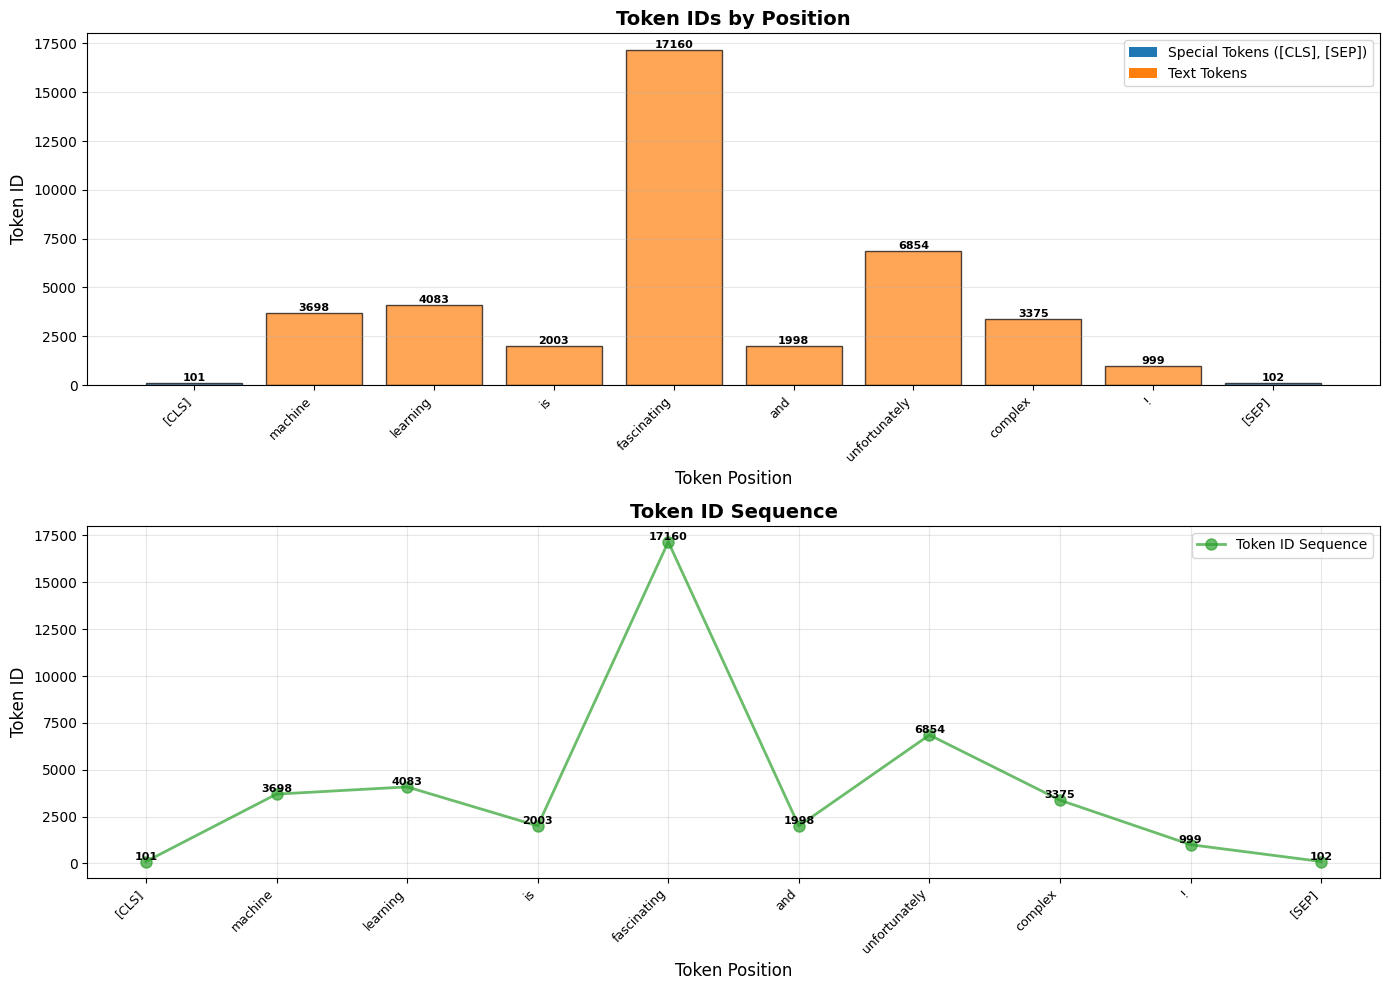


Key Observations:
  - Total tokens: 10 (including special tokens)
  - Text tokens: 8
  - Special tokens: [CLS] (ID: 101) and [SEP] (ID: 102)
  - Token ID range: 101 to 17160
  - Each token has a unique numerical ID that the model uses for processing


In [5]:
# Visualize tokenization
# Get full token IDs including special tokens for visualization
full_token_ids = tokenizer_bert.encode(example_text, add_special_tokens=True)
# Get token strings including special tokens
full_tokens = tokenizer_bert.convert_ids_to_tokens(full_token_ids)

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Token IDs as bar chart
positions = np.arange(len(full_token_ids))
colors = ['#1f77b4' if token.startswith('[') and token.endswith(']') else '#ff7f0e' 
          for token in full_tokens]

ax1.bar(positions, full_token_ids, color=colors, alpha=0.7, edgecolor='black', linewidth=1)
ax1.set_xlabel('Token Position', fontsize=12)
ax1.set_ylabel('Token ID', fontsize=12)
ax1.set_title('Token IDs by Position', fontsize=14, fontweight='bold')
ax1.set_xticks(positions)
ax1.set_xticklabels([token.replace('##', '') for token in full_tokens], rotation=45, ha='right', fontsize=9)
ax1.grid(True, alpha=0.3, axis='y')

# Add token ID labels on bars
for i, (pos, token_id) in enumerate(zip(positions, full_token_ids)):
    ax1.text(pos, token_id, str(token_id), ha='center', va='bottom', fontsize=8, fontweight='bold')

# Add legend
legend_elements = [
    Patch(facecolor='#1f77b4', label='Special Tokens ([CLS], [SEP])'),
    Patch(facecolor='#ff7f0e', label='Text Tokens')
]
ax1.legend(handles=legend_elements, loc='upper right')

# Plot 2: Token ID values as line plot
ax2.plot(positions, full_token_ids, marker='o', linewidth=2, markersize=8, 
         color='#2ca02c', alpha=0.7, label='Token ID Sequence')
ax2.set_xlabel('Token Position', fontsize=12)
ax2.set_ylabel('Token ID', fontsize=12)
ax2.set_title('Token ID Sequence', fontsize=14, fontweight='bold')
ax2.set_xticks(positions)
ax2.set_xticklabels([token.replace('##', '') for token in full_tokens], rotation=45, ha='right', fontsize=9)
ax2.grid(True, alpha=0.3)
ax2.legend(loc='best')

# Add token ID labels on points
for i, (pos, token_id) in enumerate(zip(positions, full_token_ids)):
    ax2.text(pos, token_id, str(token_id), ha='center', va='bottom', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nKey Observations:")
print(f"  - Total tokens: {len(full_token_ids)} (including special tokens)")
print(f"  - Text tokens: {len(tokens)}")
print(f"  - Special tokens: [CLS] (ID: {full_token_ids[0]}) and [SEP] (ID: {full_token_ids[-1]})")
print(f"  - Token ID range: {min(full_token_ids)} to {max(full_token_ids)}")
print("  - Each token has a unique numerical ID that the model uses for processing")


## Text to Vectors (Embeddings)

**What:** Embeddings are dense numerical vectors that represent text in a high-dimensional space. Each dimension captures some aspect of meaning, and semantically similar texts have similar vector representations.

**Why it's important:** Embeddings enable mathematical operations on text. We can measure similarity, find related content, cluster documents, and use vectors as input to other ML models. This is the core output that most NLP applications use.

**Implementation:** Using a SentenceTransformer embedding model to convert our three text samples into 384-dimensional vectors. We'll examine the properties of these vectors (dimensions, shape, value ranges) to understand their structure.

In [6]:
# Load embedding model
# Using a lightweight model that produces 384-dimensional embeddings
print("Loading embedding model...")

# Get sentence-transformers version
version = getattr(sentence_transformers, '__version__', 'unknown')
print(f"Sentence-Transformers library version: {version}")

model_name = 'all-MiniLM-L6-v2'
embedding_model = SentenceTransformer(model_name)
print("✓ Embedding model loaded successfully")
print(f"Embedding model: {model_name}")
print(f"Model produces embeddings of dimension: {embedding_model.get_sentence_embedding_dimension()}")


Loading embedding model...
Sentence-Transformers library version: 5.2.0
✓ Embedding model loaded successfully
Embedding model: all-MiniLM-L6-v2
Model produces embeddings of dimension: 384


### Generate Embeddings

In [7]:
# Generate embeddings for all texts
print("Generating embeddings...")
embeddings = {
    'text1': embedding_model.encode(texts[0]),
    'text2': embedding_model.encode(texts[1]),
    'text3': embedding_model.encode(texts[2])
}

print("✓ Embeddings generated")
print("\nVector Properties:")
print("-" * 70)
for name, emb in embeddings.items():
    print(f"\n{name.upper()}:")
    print(f"  Dimensions: {len(emb)}")
    print(f"  Shape: {emb.shape}")
    print(f"  First 5 values: {emb[:5]}")

Generating embeddings...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


✓ Embeddings generated

Vector Properties:
----------------------------------------------------------------------

TEXT1:
  Dimensions: 384
  Shape: (384,)
  First 5 values: [-0.03125835  0.01789182  0.00081864  0.02904746  0.0042486 ]

TEXT2:
  Dimensions: 384
  Shape: (384,)
  First 5 values: [-0.00726178  0.03248799  0.01984638  0.02563161 -0.00972139]

TEXT3:
  Dimensions: 384
  Shape: (384,)
  First 5 values: [-0.00279293  0.10934521  0.11284941  0.08679508  0.04860849]


## Compare Vector Similarity

**What:** Cosine similarity measures how similar two vectors are by calculating the cosine of the angle between them. It ranges from -1 (opposite) to 1 (identical), with values closer to 1 indicating more semantic similarity.

**Why it's important:** Similarity metrics are fundamental to many NLP applications: search engines, recommendation systems, duplicate detection, and clustering all rely on measuring how similar texts are. Cosine similarity is the standard metric for embeddings.

**Implementation:** Calculating cosine similarity between all pairs of our three text embeddings. We expect Text 1 and Text 2 (both about ML/AI) to have high similarity, while Text 3 (weather) should be less similar to both.

In [8]:
# Calculate cosine similarity between all pairs
def cosine_similarity(vec1, vec2):
    return np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))

print("Cosine Similarity Matrix:")
print("=" * 70)
print(f"{'':12} {'Text 1':>10} {'Text 2':>10} {'Text 3':>10}")
print("-" * 70)

text_keys = ['text1', 'text2', 'text3']
for i, name1 in enumerate(text_keys):
    row = f"{name1.upper():12}"
    for name2 in text_keys:
        sim = cosine_similarity(embeddings[name1], embeddings[name2])
        row += f" {sim:>10.4f}"
    print(row)

print("\n" + "=" * 70)
print("Interpretation:")
print("  - Values close to 1.0 = very similar (semantically related)")
print("  - Values close to 0.0 = dissimilar (different topics)")
print("  - Text 1 & Text 2 should be similar (both about ML/AI)")
print("  - Text 3 should be different (about weather)")

Cosine Similarity Matrix:
                 Text 1     Text 2     Text 3
----------------------------------------------------------------------
TEXT1            1.0000     0.5225    -0.0057
TEXT2            0.5225     1.0000    -0.0142
TEXT3           -0.0057    -0.0142     1.0000

Interpretation:
  - Values close to 1.0 = very similar (semantically related)
  - Values close to 0.0 = dissimilar (different topics)
  - Text 1 & Text 2 should be similar (both about ML/AI)
  - Text 3 should be different (about weather)


## Visualize Similarity Matrix as Heatmap

**What:** A heatmap visualizes the similarity matrix using color intensity to represent similarity values. Darker colors (or warmer colors) indicate higher similarity, making it easy to see relationships at a glance.

**Why it's important:** Visual representations help us quickly understand patterns in the data. The heatmap makes it immediately obvious which texts are similar and which are different, complementing the numerical similarity scores.

**Implementation:** Creating a heatmap using seaborn to display the cosine similarity matrix with color-coded values and labels for each text pair.

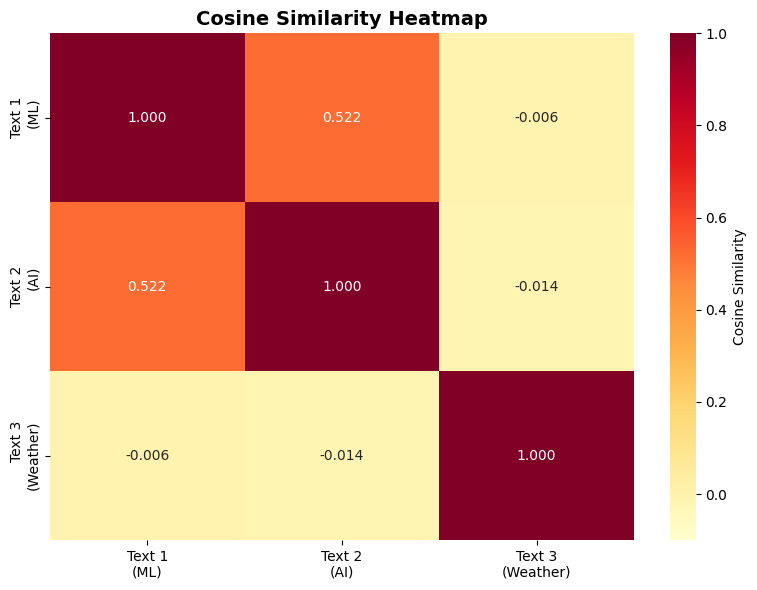


Key Observations:
  - Text 1 and Text 2 show high similarity (warm colors)
  - Text 3 shows low similarity with both ML/AI texts (cool colors)
  - Diagonal is always 1.0 (each text is identical to itself)


In [9]:
# Create similarity matrix for visualization
text_keys = ['text1', 'text2', 'text3']  # Define text keys for iteration
similarity_matrix = np.zeros((3, 3))
text_labels = ['Text 1\n(ML)', 'Text 2\n(AI)', 'Text 3\n(Weather)']

for i, name1 in enumerate(text_keys):
    for j, name2 in enumerate(text_keys):
        similarity_matrix[i, j] = cosine_similarity(embeddings[name1], embeddings[name2])

# Create heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(similarity_matrix, 
            annot=True, 
            fmt='.3f', 
            cmap='YlOrRd', 
            xticklabels=text_labels,
            yticklabels=text_labels,
            vmin=-0.1, 
            vmax=1.0,
            cbar_kws={'label': 'Cosine Similarity'})
plt.title('Cosine Similarity Heatmap', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nKey Observations:")
print("  - Text 1 and Text 2 show high similarity (warm colors)")
print("  - Text 3 shows low similarity with both ML/AI texts (cool colors)")
print("  - Diagonal is always 1.0 (each text is identical to itself)")

## Visualize Embedding Vector Structure

**What:** Plotting the raw embedding vectors as line plots to see their structure. Each vector has 384 dimensions, and we can visualize how the values vary across dimensions.

**Why it's important:** This visualization helps us understand that embeddings are dense vectors with meaningful patterns. Similar texts should have similar patterns in their vector representations, even if we can't see all 384 dimensions at once.

**Implementation:** Plotting the first 50 dimensions of each embedding vector to show their structure and compare patterns between similar and dissimilar texts.

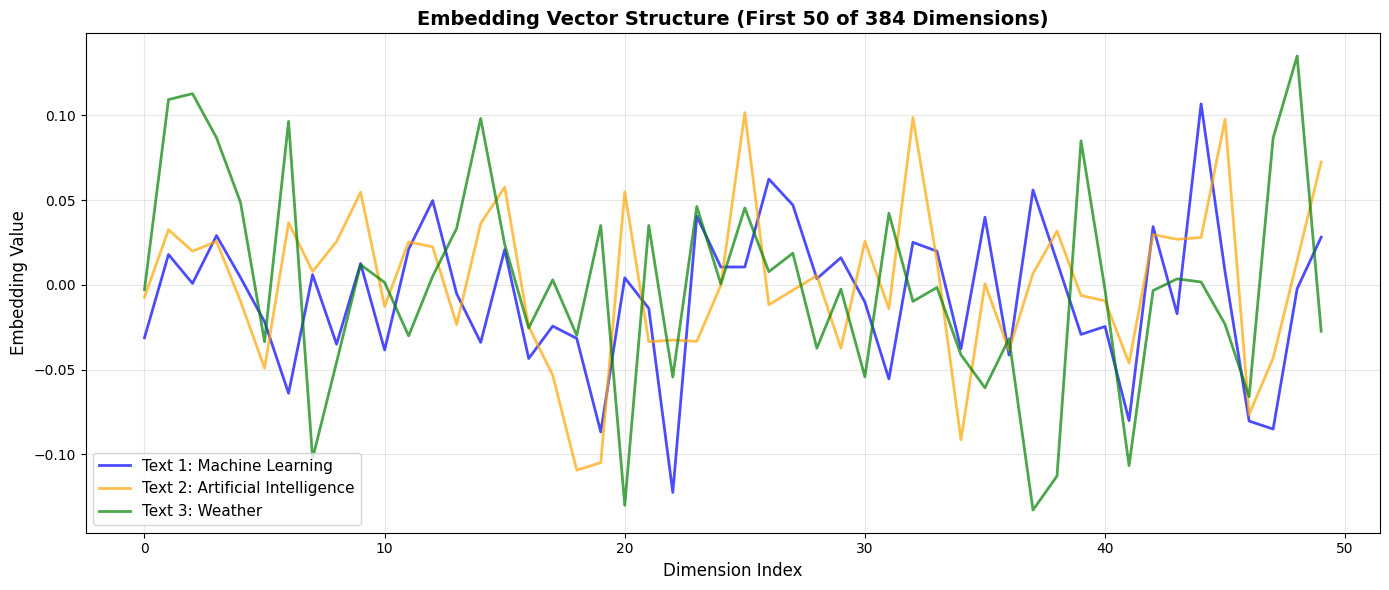

Key Observations:
  - Each text has a unique pattern across dimensions
  - Text 1 and Text 2 show similar patterns (both about ML/AI)
  - Text 3 shows a different pattern (about weather)
  - These patterns encode semantic meaning in the high-dimensional space


In [10]:
# Visualize first 50 dimensions of each embedding
plt.figure(figsize=(14, 6))
dimensions_to_plot = 50
x = np.arange(dimensions_to_plot)

plt.plot(x, embeddings['text1'][:dimensions_to_plot], 'b-', alpha=0.7, linewidth=2, label='Text 1: Machine Learning')
plt.plot(x, embeddings['text2'][:dimensions_to_plot], 'orange', alpha=0.7, linewidth=2, label='Text 2: Artificial Intelligence')
plt.plot(x, embeddings['text3'][:dimensions_to_plot], 'g-', alpha=0.7, linewidth=2, label='Text 3: Weather')

plt.xlabel('Dimension Index', fontsize=12)
plt.ylabel('Embedding Value', fontsize=12)
plt.title(f'Embedding Vector Structure (First {dimensions_to_plot} of 384 Dimensions)', fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Key Observations:")
print("  - Each text has a unique pattern across dimensions")
print("  - Text 1 and Text 2 show similar patterns (both about ML/AI)")
print("  - Text 3 shows a different pattern (about weather)")
print("  - These patterns encode semantic meaning in the high-dimensional space")


## Visualize Embeddings in 3D Space


**What:** Using Principal Component Analysis (PCA) to reduce the 384-dimensional embeddings to 3D for visualization. PCA finds the directions of maximum variance in the data, allowing us to see how texts cluster in a 3D space.

**Why it's important:** High-dimensional vectors are impossible to visualize directly. PCA gives us an intuitive way to see how similar texts group together in space. Texts that are semantically similar should appear close to each other in the 3D plot.

**Implementation:** Reducing embeddings from 384 dimensions to 3 using PCA, then plotting them on a 3D scatter plot with labels.


Variance explained by 3D projection: 100.0%
  - PC1: 71.3%
  - PC2: 28.7%
  - PC3: 0.0%


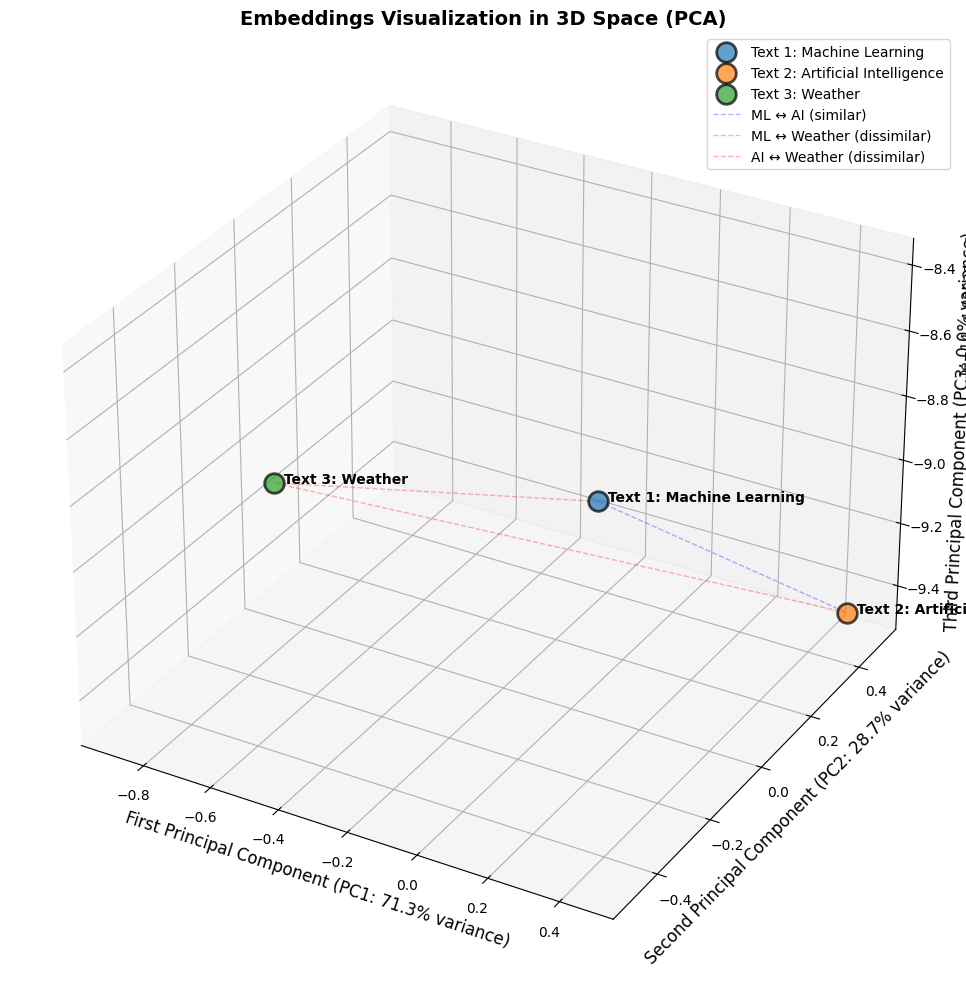


Key Observations:
  - Text 1 and Text 2 are close together (similar topics)
  - Text 3 is far from both ML/AI texts (different topic)
  - Distance in 3D space reflects semantic similarity


In [11]:
# Prepare embeddings for PCA
embedding_array = np.array([embeddings['text1'], embeddings['text2'], embeddings['text3']])

# Apply PCA to reduce from 384 dimensions to 3
pca = PCA(n_components=3)
embeddings_3d = pca.fit_transform(embedding_array)

# Calculate variance explained
variance_explained = pca.explained_variance_ratio_
total_variance = variance_explained.sum()

print(f"Variance explained by 3D projection: {total_variance:.1%}")
print(f"  - PC1: {variance_explained[0]:.1%}")
print(f"  - PC2: {variance_explained[1]:.1%}")
print(f"  - PC3: {variance_explained[2]:.1%}")

# Create 3D visualization
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
labels = ['Text 1: Machine Learning', 'Text 2: Artificial Intelligence', 'Text 3: Weather']

for i, (point, color, label) in enumerate(zip(embeddings_3d, colors, labels)):
    ax.scatter(point[0], point[1], point[2], s=200, c=color, alpha=0.7, edgecolors='black', linewidth=2, label=label)
    ax.text(point[0], point[1], point[2], f'  {label}', fontsize=10, fontweight='bold')

# Draw lines between points to show relationships
ax.plot([embeddings_3d[0][0], embeddings_3d[1][0]], 
        [embeddings_3d[0][1], embeddings_3d[1][1]], 
        [embeddings_3d[0][2], embeddings_3d[1][2]], 
        'b--', alpha=0.3, linewidth=1, label='ML ↔ AI (similar)')
ax.plot([embeddings_3d[0][0], embeddings_3d[2][0]], 
        [embeddings_3d[0][1], embeddings_3d[2][1]], 
        [embeddings_3d[0][2], embeddings_3d[2][2]], 
        'r--', alpha=0.3, linewidth=1, label='ML ↔ Weather (dissimilar)')
ax.plot([embeddings_3d[1][0], embeddings_3d[2][0]], 
        [embeddings_3d[1][1], embeddings_3d[2][1]], 
        [embeddings_3d[1][2], embeddings_3d[2][2]], 
        'r--', alpha=0.3, linewidth=1, label='AI ↔ Weather (dissimilar)')

ax.set_xlabel(f'First Principal Component (PC1: {variance_explained[0]:.1%} variance)', fontsize=12)
ax.set_ylabel(f'Second Principal Component (PC2: {variance_explained[1]:.1%} variance)', fontsize=12)
ax.set_zlabel(f'Third Principal Component (PC3: {variance_explained[2]:.1%} variance)', fontsize=12)
ax.set_title('Embeddings Visualization in 3D Space (PCA)', fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=10)
plt.tight_layout()
plt.show()

print("\nKey Observations:")
print("  - Text 1 and Text 2 are close together (similar topics)")
print("  - Text 3 is far from both ML/AI texts (different topic)")
print("  - Distance in 3D space reflects semantic similarity")
